<h1><center> Metapopulation Model with SIR <br><br> 
<center> NetworkX Application<br><br> 
Wendy Shi</center></center>

# Table of Content

1. [Seeding Events](#Seeding-Events)
2. [Node Dictionary](#Node-Dictionary)
3. [US Shape File](#US-Shape-File)
4. [One simulation](#One-simulation)
5. [20 Simulation](#20-Simulation)



# Preparation

In [1]:
#Preparation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import scipy.stats as stats

# Seeding Events

In [34]:
column_names = ['S', 'E', 'I', 'R']
Seeding = pd.read_csv("../../Data/seed_1503_seed_corrected_undereporting_CDC_corrected_v3.txt",
                     delimiter=' ',
                      names=column_names)
Seeding['index'] = range(len(Seeding))
print(Seeding.shape)
Seeding.head(3)

(2327, 5)


,S,E,I,R,index
0,58877,0,0,0,0
1,233140,0,0,0,1
2,25180,0,0,0,2


In [35]:
multiplier = Seeding["S"].tolist()
multiplier[:3]

[58877, 233140, 25180]

# Node Dictionary

In [36]:
node_dict = pd.read_csv("../../Data/nodes_considered.csv")
node_dict["GEO_ID"] = node_dict["GEO_ID"].apply(lambda x: f"{int(x):05d}")
node_dict["State Code"] = node_dict["GEO_ID"].str[:2]
print(node_dict.shape)
node_dict.head(3)

(2327, 3)


,index,GEO_ID,State Code
0,0,01001,01
1,1,01003,01
2,2,01005,01


In [37]:
IL = node_dict[node_dict["State Code"] == '17']
IL_SEIR = pd.merge(IL, Seeding, on = 'index', how = 'inner')
#IL_SEIR = IL_SEIR.drop(columns=['index']) #Drop the index when merging SEIR and New York GEOID

rename = {'GEO_ID' : 'GEOID'}
IL_SEIR = IL_SEIR.rename(columns = rename)

print(IL_SEIR.shape)
IL_SEIR.head(3)

(86, 7)


,index,GEOID,State Code,S,E,I,R
0,450,17001,17,65530,0,0,0
1,451,17005,17,16663,0,0,0
2,452,17007,17,53326,0,0,0


# Safegraph Data

In [43]:
#Open the 12 weight matrix
index = IL_SEIR['index'].tolist()
pop_list = IL_SEIR['S'].tolist()

#retrieve data
column_names = ['origin', 'destination', 'count', 'weight']
for i in range(12):
    n = i +1
    
    df = pd.read_csv(f"../../Data/monthly_matrix_sd_county_month{n}_county.txt", 
                     delimiter=' ', names=column_names)
    
    #Making sure all origin and destination are states in New York
    df = df[(df['origin'].isin(index)) & (df['destination'].isin(index))]
    
    # Store the modified DataFrame
    globals()[f'wt_mt{n}'] = df

In [44]:
wt_mt12.head(3)

,origin,destination,count,weight
867199,450,452,12,0.000087
867200,452,452,12,0.537017
867201,453,452,12,0.000875


In [45]:
#Turn each data into a matrix
#Transform the dataframe to a matrix with pivot table
for i in range(12):
    n = i+1
    matrix = globals()[f'wt_mt{n}'].pivot_table(index='origin', 
                                                columns='destination', 
                                                values= 'weight', fill_value=0)
    matrix = matrix.reset_index()
    matrix = matrix.drop(columns = ["origin"]) #drop the origin column
    globals()[f'matrix{n}'] = matrix

In [46]:
for i in range(12):
    n = i +1
    count_df = globals()[f'matrix{n}'].multiply(pop_list, axis=0)
    globals()[f'count_df{n}'] = count_df

In [47]:
average_count_df = sum(globals()[f'count_df{i}'] for i in range(1, 13)) / 12
print(average_count_df.shape)
average_count_df.head(3)

(86, 86)


destination,450,451,452,453,454,455,456,457,458,459,...,526,527,528,529,530,531,532,533,534,535
0,52111.933459,10.720519,6.337626,8.520464,12.337215,54.889411,27.811519,11.127344,6.966946,3.261686,...,7.19764,21.241370,7.850215,6.916519,6.683061,13.186394,27.665742,11.574378,9.637898,11.253416
1,10.425786,8254.570877,1.281018,3.985297,1.361914,7.133835,14.836756,13.552659,10.917038,8.781372,...,2.29854,5.491941,22.132376,12.731866,7.636642,7.626253,8.669282,16.602062,7.626894,6.972749
2,13.997021,3.667755,28612.151251,25.055111,18.401346,3.729596,40.846615,5.096730,6.468429,2.384429,...,3.11652,6.184460,1.815156,1.375360,2.195027,39.005533,77.033460,7.937531,10283.803765,12.073622


In [48]:
#Turn count to weight
divisor = [average_count_df.iloc[i].sum() for i in range(86)]
average_wt_mt = average_count_df.div(divisor, axis=0)
average_wt_mt.head(3)

destination,450,451,452,453,454,455,456,457,458,459,...,526,527,528,529,530,531,532,533,534,535
0,0.954115,0.000196,0.000116,0.000156,0.000226,0.001005,0.000509,0.000204,0.000128,0.000060,...,0.000132,0.000389,0.000144,0.000127,0.000122,0.000241,0.000507,0.000212,0.000176,0.000206
1,0.000830,0.656912,0.000102,0.000317,0.000108,0.000568,0.001181,0.001079,0.000869,0.000699,...,0.000183,0.000437,0.001761,0.001013,0.000608,0.000607,0.000690,0.001321,0.000607,0.000555
2,0.000316,0.000083,0.646386,0.000566,0.000416,0.000084,0.000923,0.000115,0.000146,0.000054,...,0.000070,0.000140,0.000041,0.000031,0.000050,0.000881,0.001740,0.000179,0.232325,0.000273


In [49]:
ori_array = average_wt_mt.to_numpy()

# US Shape File

In [7]:
us_shape_file = pd.read_csv("../../Data/us_shapefile_county.csv")

us_shape_file = us_shape_file[['NAME', 'State_1', 'FIPS code', 'pop2020']].copy()
rename = {'State_1' : 'State'}
us_shape_file = us_shape_file.rename(columns = rename)

us_shape_file["FIPS code"] = us_shape_file["FIPS code"].apply(lambda x: f"{int(x):05d}")

#rename column
rename = {"FIPS code" : "GEOID"}
us_shape_file = us_shape_file.rename(columns = rename)
us_shape_file.tail(3)

,NAME,State,GEOID,pop2020
3106,Los Angeles,California,06037,9989165.0
3107,Shannon,South Dakota,46113,14309.0
3108,Bedford,Virginia,51515,6599.0


In [10]:
IL_name= us_shape_file[us_shape_file['State'] == "Illinois"].copy()
print(IL_name.shape)
IL_name.head(3)

(102, 4)


,NAME,State,GEOID,pop2020
217,Hardin,Illinois,17069,3634.0
226,Pope,Illinois,17151,3744.0
268,Calhoun,Illinois,17013,4411.0


In [11]:
IL_SEIR_name = IL_SEIR.merge(IL_name, on = 'GEOID', how = 'left')
IL_SEIR_list = IL_SEIR_name['GEOID'].tolist() #The GEOID as what is appeares in the dataframe

print(IL_SEIR_name.shape)
IL_SEIR_name.head(3)

(86, 9)


,GEOID,State Code,S,E,I,R,NAME,State,pop2020
0,17001,17,65530,0,0,0,Adams,Illinois,65530.0
1,17005,17,16663,0,0,0,Bond,Illinois,16663.0
2,17007,17,53326,0,0,0,Boone,Illinois,53326.0


In [17]:
IL_SEIR_name.to_excel("IL_SEIR_name.xlsx")

# Retrieve Data

In [18]:
#Original matrix for comparison
matrix = pd.read_csv("IL_Data/Aggregate/IL_ori_agg.csv")
matrix = matrix.drop(columns = 'Unnamed: 0')
matrix.head(3)

,17001,17005,17007,17011,17015,17017,17019,17021,17023,17025,...,17185,17187,17189,17191,17193,17195,17197,17199,17201,17203
0,0.844666,0.000223,0.000160,0.000160,0.000000,0.000511,0.000383,0.000096,0.000351,0.001053,...,0.000096,0.000128,0.000096,0.0000,0.0,0.000638,0.007690,0.002617,0.005074,0.000000
1,0.000133,0.298000,0.000000,0.000000,0.000000,0.001467,0.034000,0.012000,0.000133,0.001733,...,0.000000,0.000267,0.000800,0.0028,0.0,0.003733,0.012400,0.016667,0.001733,0.001067
2,0.000000,0.000000,0.403862,0.000105,0.001679,0.000000,0.002624,0.000000,0.000000,0.000000,...,0.000000,0.004723,0.000000,0.0000,0.0,0.004198,0.021935,0.000000,0.158795,0.000000


In [19]:
matrix_county_list = matrix.columns.tolist()
print(f'SEIR county list = Weight Matrix County List?: {matrix_county_list == IL_SEIR_list}') #Proceed when see Yes

array = matrix.to_numpy() #The most important step!! Turning pandas dataframe to a numpy array
array[0][0]

SEIR county list = Weight Matrix County List?: True


0.8446663901209355

# One simulation

In [20]:
def stochastic_SIR(y, l, array):
    
    # y is the list that contains the initial condition of S_i, I_i, R_i
    S = y[:l]  # a five element list
    E = y[l:l+l]
    I = y[l+l:l+l+l]  # a five element list
    R = y[l+l+l:]  # the rest elements
    
    t = 0
    time_series = [(t, S.copy(), E.copy(), I.copy(), R.copy())]
    
    #l = len(S)
    
    # Define each element of N
    N = [S[i] + E[i] + I[i] + R[i] for i in range(l)]
    
    # Define N_hat
    N_hat = [array[i][i] * N[i] for i in range(l)]
    for i in range(l):
        for j in range(l):
            if i != j:
                N_hat[i] += array[j][i] * N[j]
    
    #print(N_hat)
    
    # Run the loop ------------------------------------
    t_max = 50
    #while any(i > 0 for i in I) and t < t_max: #time stamp loop--
    while t < t_max:
        
        #Define value for beta
        if t < 25: 
            beta = 3.5
        else: 
            beta = 1.7
        
        for i in range(l): #node loop------
            
            # Define I_hat for all nodes
            I_hat = [array[i][i] * I[i] for i in range(l)]
            for j in range(l):
                if i != j:
                    I_hat[i] += array[j][i] * I[j]
            
            # Calculate lambda
            lmda = beta * (array[i][i] ** 2) * I[i] / N_hat[i]
            for j in range(l):
                if i != j:
                    lmda += (beta * array[i][i] * array[j][i] * I[j] / N_hat[i]) + (beta * array[i][j] * I_hat[j] / N_hat[j])
            
            #Newly added term, having b equals to 3.5 and largrer sample of nodes makes lamda larger than 1
            lmda_new = min(lmda,1)
            
            #Check again to see if you can improve the model-------------
            new_exposed = np.random.binomial(S[i], lmda_new)*1
            new_infected = np.random.binomial(E[i], 0.2703)*1
            new_recovered = np.random.binomial(I[i], 0.2448)*1 
            
            # Update S, I, R for node i
            S[i] -= new_exposed
            E[i] += new_exposed - new_infected
            I[i] += new_infected - new_recovered
            R[i] += new_recovered
        
        # Store the results (make copies to avoid overwriting)
        time_series.append((t, S.copy(), E.copy(), I.copy(), R.copy()))
        
        # Increment time (optional)
        t += 1
        #print(f"Time: {t}, S: {S}, I: {I}, R: {R}")
        if t % 10 == 0:
            print(t)
    
    return time_series

# Applying for the function
### Original Array

In [21]:
#NY_SEIR = pd.read_excel("NY_SEIR.xlsx")
#NY_SEIR = NY_SEIR.drop(columns = 'Unnamed: 0')
#NY_SEIR.iloc[15:20]

In [22]:
#Define initial condition
S0 = AZ_SEIR["S"].tolist()  
E0 = AZ_SEIR["E"].tolist()  
I0 = AZ_SEIR["I"].tolist()   
R0 = AZ_SEIR["R"].tolist()
initial_conditions = S0 + E0 + I0 + R0 #this is the y (?): Yup!
print(len(S0),len(E0),len(I0), len(R0))

86 86 86 86


In [53]:
#first simulation
time_series = stochastic_SIR(initial_conditions, 86, ori_array)

10
20
30
40
50


In [54]:
times, S_values, E_values, I_values, R_values = zip(*time_series)

S_list = list(zip(*S_values))
for i, S in enumerate(S_list):
    globals()[f'S{i}'] = S
    
E_list = list(zip(*E_values))
for i, E in enumerate(E_list):
    globals()[f'E{i}'] = E
    
I_list = list(zip(*I_values))
for i, I in enumerate(I_list):
    globals()[f'I{i}'] = I
    
R_list = list(zip(*R_values))
for i, R in enumerate(R_list):
    globals()[f'R{i}'] = R

<br>

- **globals()** is a built-in function in Python that returns a dictionary representing the current global symbol table. The global symbol table contains all the global variables in the program. When you do globals()[f'S{i}'] = s, you're dynamically creating a new global variable with a name like S1, S2, etc., and assigning it the value s. In this case, f'S{i}' generates the variable name as a string, and s is the corresponding value from the list.

<br>

- **enumerate()** is a built-in Python function that allows you to loop over an iterable (like a list, tuple, or string) while also keeping track of the index of each element.When used like enumerate(S_list, start=1), it returns pairs of (index, value), where index starts at 1 and increases by 1 for each iteration, while value is the corresponding item from the list. The start=1 parameter means that the counting will begin at 1 instead of the default 0.

# Visualization: One Loop

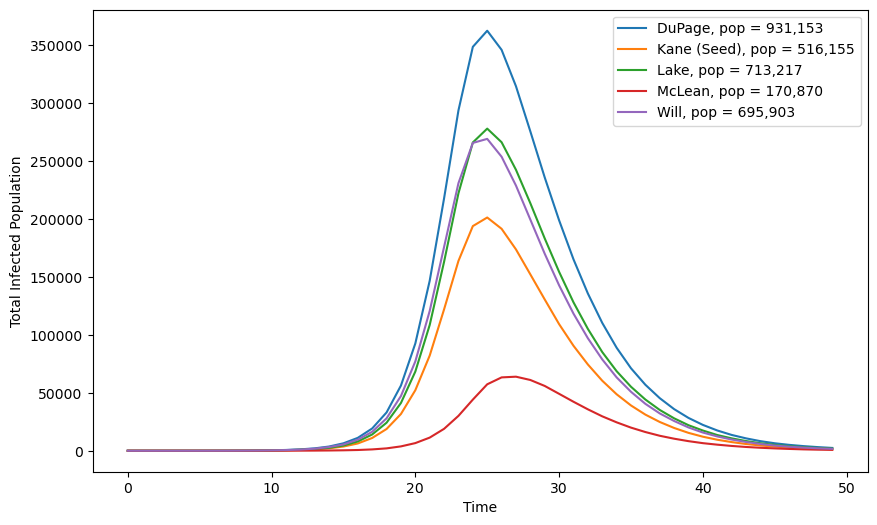

In [55]:
plt.figure(figsize=(10,6))

plt.plot(times, I17, label='DuPage, pop = 931,153')
plt.plot(times, I34, label='Kane (Seed), pop = 516,155')
plt.plot(times, I38, label='Lake, pop = 713,217')
plt.plot(times, I46, label='McLean, pop = 170,870')
plt.plot(times, I82, label='Will, pop = 695,903')

plt.xlabel('Time')
plt.ylabel('Total Infected Population')
plt.legend()
#plt.savefig("CA_SEIR_Example.png", dpi=300, bbox_inches='tight')

plt.show()



### Scikit Mobility Original matrix

In [63]:
ori_array[1][1]

0.6569115924295615

In [64]:
array[1][1]

0.298

In [65]:
time_series = stochastic_SIR(initial_conditions, 86, array)

10
20
30
40
50


In [57]:
times, S_values, E_values, I_values, R_values = zip(*time_series)

S_list = list(zip(*S_values))
for i, S in enumerate(S_list):
    globals()[f'S{i}'] = S
    
E_list = list(zip(*E_values))
for i, E in enumerate(E_list):
    globals()[f'E{i}'] = E
    
I_list = list(zip(*I_values))
for i, I in enumerate(I_list):
    globals()[f'I{i}'] = I
    
R_list = list(zip(*R_values))
for i, R in enumerate(R_list):
    globals()[f'R{i}'] = R

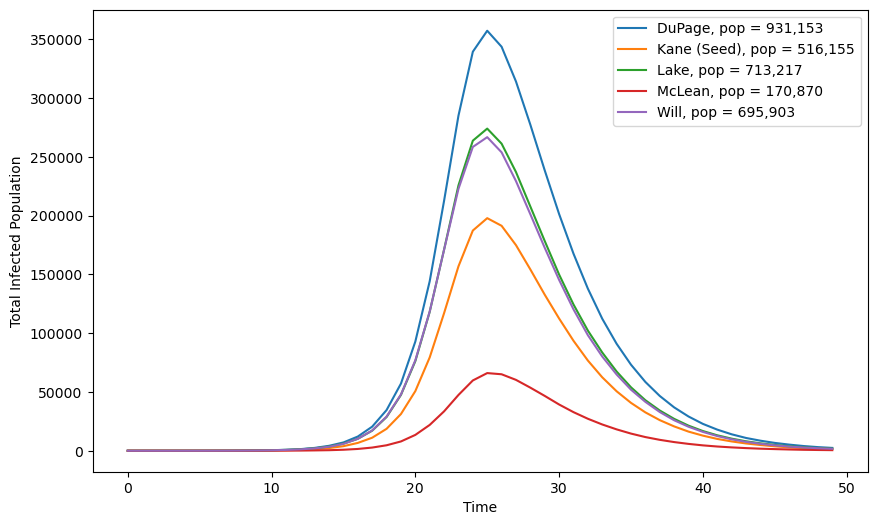

In [66]:
plt.figure(figsize=(10,6))

plt.plot(times, I17, label='DuPage, pop = 931,153')
plt.plot(times, I34, label='Kane (Seed), pop = 516,155')
plt.plot(times, I38, label='Lake, pop = 713,217')
plt.plot(times, I46, label='McLean, pop = 170,870')
plt.plot(times, I82, label='Will, pop = 695,903')

plt.xlabel('Time')
plt.ylabel('Total Infected Population')
plt.legend()
#plt.savefig("CA_SEIR_Example.png", dpi=300, bbox_inches='tight')

plt.show()


# 20 Simulation

In [151]:
matrix = pd.read_csv("IL_Data/Aggregate/IL_ori_agg.csv")
matrix = matrix.drop(columns = 'Unnamed: 0')
matrix.head(3)

array = matrix.to_numpy() #The most important step!! Turning pandas dataframe to a numpy array
array[0][0]

0.8446663901209355

In [152]:
all_simulations = []

for sim in range(20):
    
    S0 = IL_SEIR["S"].tolist()  
    E0 = IL_SEIR["E"].tolist()  
    I0 = IL_SEIR["I"].tolist()   
    R0 = IL_SEIR["R"].tolist()
    initial_conditions = S0 + E0 + I0 + R0 #this is the y (?): Yup!

    result = stochastic_SIR(initial_conditions, 86, array)
    print("Simulation", sim, "Finished!!!-------------------------------")
    
    all_simulations.append(result)

10
20
30
40
50
Simulation 0 Finished!!!-------------------------------
10
20
30
40
50
Simulation 1 Finished!!!-------------------------------
10
20
30
40
50
Simulation 2 Finished!!!-------------------------------
10
20
30
40
50
Simulation 3 Finished!!!-------------------------------
10
20
30
40
50
Simulation 4 Finished!!!-------------------------------
10
20
30
40
50
Simulation 5 Finished!!!-------------------------------
10
20
30
40
50
Simulation 6 Finished!!!-------------------------------
10
20
30
40
50
Simulation 7 Finished!!!-------------------------------
10
20
30
40
50
Simulation 8 Finished!!!-------------------------------
10
20
30
40
50
Simulation 9 Finished!!!-------------------------------
10
20
30
40
50
Simulation 10 Finished!!!-------------------------------
10
20
30
40
50
Simulation 11 Finished!!!-------------------------------
10
20
30
40
50
Simulation 12 Finished!!!-------------------------------
10
20
30
40
50
Simulation 13 Finished!!!-------------------------------
10

In [153]:
import pickle

with open('20_simulations_ori_IL_agg.pkl', 'wb') as f:
    pickle.dump(all_simulations, f)